In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_immo = pd.read_csv('immo_data.csv')

data,test_set = train_test_split(data_immo,train_size = 0.8,random_state = 42)

In [ ]:
len(test_set)

53770

# WHAT TO PREDICT?

Since we have a lot of data of totalRent that is missing I will divide the task into 2: predicting baseRent and price_costs. So that I can use all the data for baseRent and the avaliable to predict the costs.

### Predict baseRent price per Square meter or price of the whole property?

                                        Plots for livingSpace                                         


/home/guillermogarcia/anaconda3/envs/Guille/lib/python3.7/site-packages/featexp/base.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data[feature] = input_data[feature].round(5)


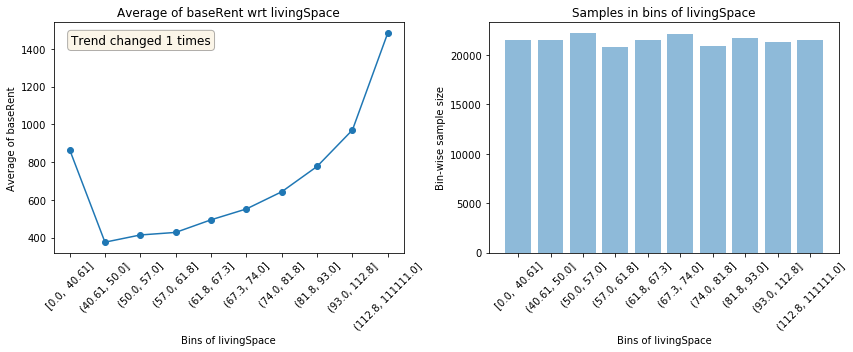

--------------------------------------------------------------------------------------------------------------




In [ ]:
#check the correlation between livingSpace and baseRent
from featexp import get_univariate_plots

get_univariate_plots(data = data, target_col = 'baseRent', features_list = ['livingSpace'])

In [ ]:
def func(x):
    maxi = 300
    bins = [i for i in range(0,maxi,10)]
    for j in range(len(bins)):
        if (bins[j] == (maxi -10)):
            return bins[j]
        if ((x > bins[j]) & (x < bins[j+1])):
            return bins[j]
data["livingSpace_bin"] = data["livingSpace"].apply(func)

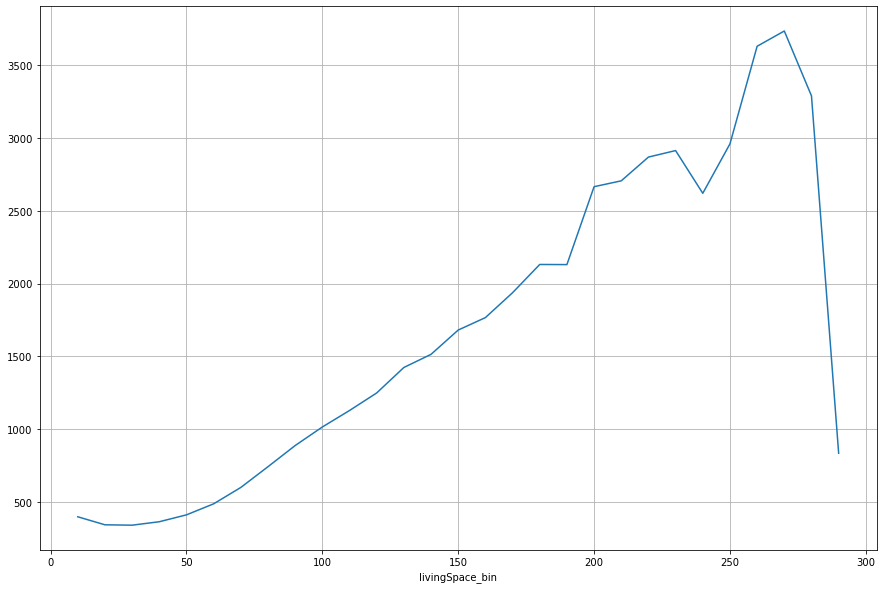

In [ ]:
sel = data['livingSpace_bin'] > 0
data[sel].groupby('livingSpace_bin')['baseRent'].mean().plot(grid = True,figsize = (15,10))

Most of the hauses have a livingSpace 30 and 150 square meters. In that region (and until 200 or a bit more) the hauses present a clear linear dependence with the price (which makes totally sense). If we already know this relationship doesn't make sense that a model learns it since we already know it.
Let's see if it's more stable to predict the price in general or per square meter.

So should we predict the Price per square meter or the direct price?
Look at the standard deviation of the two approaches in the prices from each bundesland. The one with lowesttandard deviation will tell us that the homogeniety of that group is higher and therefore easier to generalize

In [ ]:
data['baseRentSquareMeter'] = data['baseRent'] / data['livingSpace']

In [ ]:
sel = data['livingSpace'] > 10
data[sel].groupby('geo_bln')['baseRentSquareMeter'].std().sum()

81.09701375207601

In [ ]:
sel = data['livingSpace'] > 10
(data[sel].groupby('geo_bln')['baseRent'].std() / data[sel].groupby('geo_bln')['livingSpace'].mean()).sum()

100.74336648905071

### Predict extra costs per square meter or as a whole?

In [ ]:
data['price_costs'] = data['totalRent'] - data['baseRent']

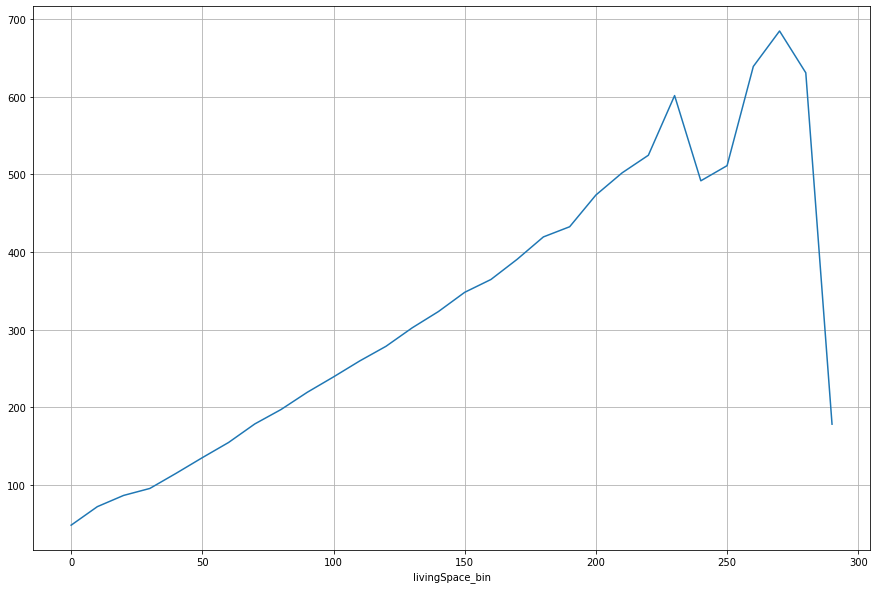

In [ ]:
data.groupby('livingSpace_bin')['price_costs'].mean().plot(grid = True,figsize = (15,10))

I will also plot priceCosts / livingSpace

# Clean targets

In [ ]:
def create_new_features_target(data):
    data['baseRentSquareMeter'] = data['baseRent'] / data['livingSpace']
    data['price_costs'] = data['totalRent'] - data['baseRent']
    data['price_costs_square_meter'] = data['price_costs'] / data['livingSpace']
    return data

In [ ]:
def clean_possible_errors(data):
    
    #if price is 0 it's an error
    data['totalRent'].replace(0, np.nan, inplace=True) 
    data['baseRent'].replace(0, np.nan, inplace=True)
    
    #Hauses with no livingSpace are wrong
    sel0 = (data['livingSpace'] == 0)
    
    #Unusual high values of baseRent
    sel1 = (data['livingSpace'] <= 10) & (data['baseRentSquareMeter'] > 50)
    sel1prima = (data['baseRent'] > 50000)
    sel1primaprima = (data['baseRentSquareMeter'] > 200)
    
    #Houses with more than one room and with less than 10 square meter are probably wrong
    sel2 = (data['livingSpace'] < 10) & (data['noRooms'] > 1)
    
    #Unusual high values of priceCosts
    sel3 = (data['price_costs_square_meter'] > 50)
    
    #Unusual low values of baseRent
    sel4 = (data['baseRentSquareMeter'] < 1) & (data['baseRent'] < 100)
    
    #Unusual low values of priceCosts
    sel5 = (data['price_costs'] < 0)
    
    print(len(data[(sel0 | sel1 | sel1prima | sel1primaprima | sel2 | sel3 | sel4 | sel5)]),'data points removed!')
    
    return data[~(sel0 | sel1 | sel1prima | sel1primaprima | sel2 | sel3 | sel4 | sel5)]

##### How did you get the values for the intervals to clean the targets?


Answer: By looking at different intervals and seeing how the hauses are in the selection. For example to see the hauses with livingSpace < 5 (see cell below), I realize that it does not make sense to have less than 5 square meters and to have 3.5 rooms beacause each room would be not even 2 square meters. This is obviously an error. So I look at the unusual values from each feature and its correlation with the others to be able to judge if a haus makes sense or not. To get the intervals to look at the houses I just plot the histogram of values of the feature and see at the atypical values.

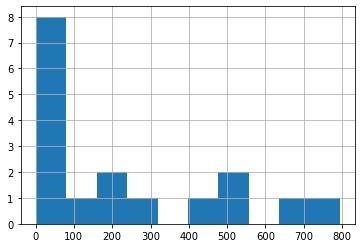

In [ ]:
#Example histogram to decide thresholds
sel = (data['livingSpace'] < 5) & (data['livingSpace'] != 0) & (data['baseRentSquareMeter'] < 600000)
data[sel]['baseRentSquareMeter'].hist()

In [ ]:
#Example to look at the hauses
sel = (data['livingSpace'] < 5)
data[sel][['noRooms','livingSpace','baseRent','baseRentSquareMeter','totalRent','price_costs']]

,noRooms,livingSpace,baseRent,baseRentSquareMeter,totalRent,price_costs
97255,3.5,0.0,840.0,inf,960.0,120.0
9343,1.5,1.0,795.0,795.000000,795.0,0.0
229099,3.5,0.0,770.0,inf,910.0,140.0
19381,1.0,3.0,50.0,16.666667,50.0,0.0
203713,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
167330,4.0,1.0,200.0,200.000000,250.0,50.0
211909,2.0,2.0,400.0,200.000000,NaN,NaN
151681,3.0,0.0,559.0,inf,NaN,NaN
91491,3.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
data = create_new_features_target(data)
data_clean = clean_possible_errors(data)

513 data points removed!


In [ ]:
data_clean['price_costs'].isnull().sum()

32458

In [ ]:
data_clean['baseRent'].isnull().sum()

59

# Clean features

In [ ]:
from data import *
from featexp import get_univariate_plots

In [ ]:
target_class = 'totalRent'
ignore_features = ["scoutId", "pricetrend", "yearConstructedRange", "noRoomsRange",
                   "livingSpaceRange", "thermalChar", "street", "picturecount", "date"]

#Boolean features
bool_features = ['newlyConst','balcony','hasKitchen','cellar','lift','garden']

#Categorical
transform2categorical = ['heatingType','telekomTvOffer','firingTypes','condition','interiorQual',
                         'typeOfFlat','energyEfficiencyClass','electricityBasePrice','petsAllowed'] 

#Continuous
continuous_features = ['serviceCharge','noParkSpaces',
                     'baseRent','livingSpace','baseRentRange',
                     'noRooms','floor','numberOfFloors',
                     'heatingCosts','electricityKwhPrice'] 

telekom_features = ['telekomUploadSpeed','telekomHybridUploadSpeed']

transform2continuous = ['date','yearConstructed','lastRefurbish']

#Location
location_features = ['regio1','regio2','regio3','geo_bln','geo_krs','geo_plz','streetPlain']

In [ ]:
# How many missing values?
features = list(set(data.columns) - set(ignore_features))
data[features].isnull().sum()

interiorQual                 90065
facilities                   42178
streetPlain                  56873
telekomTvOffer               26018
newlyConst                       0
geo_bln                          0
lift                             0
firingTypes                  45645
baseRent                        69
regio2                           0
floor                        41097
noRooms                          0
livingSpace                      0
price_costs_square_meter     32745
baseRentRange                    0
regio1                           0
description                  15794
condition                    54855
energyEfficiencyClass       152858
heatingType                  35813
geo_plz                          0
totalRent                    32694
geo_krs                          0
petsAllowed                  91659
hasKitchen                       0
lastRefurbish               150723
telekomUploadSpeed           26601
cellar                           0
yearConstructed     

## Boolean features

newlyConst [False  True]
balcony [False  True]
hasKitchen [False  True]
cellar [ True False]
lift [False  True]
garden [ True False]


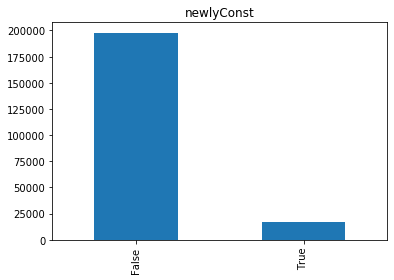

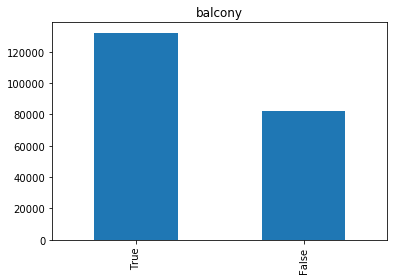

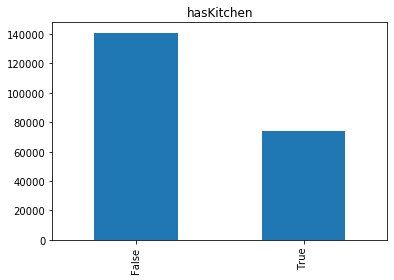

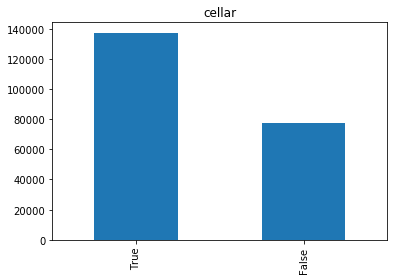

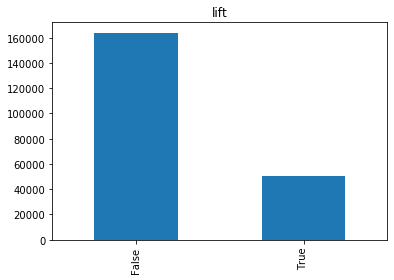

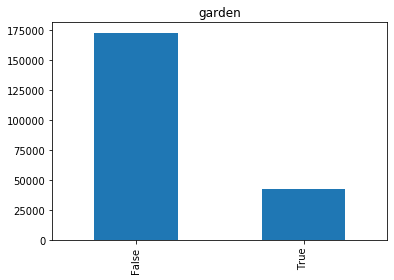

In [ ]:
describe_data(training_data = data_clean[bool_features],categorical = True)

In [ ]:
def trans_bool_features(data,bool_features):
    for col_bool in bool_features: 
        data[col_bool] = data[col_bool].astype(int)
    return data

data_clean = trans_bool_features(data = data_clean,
                                bool_features = bool_features)

                                         Plots for newlyConst                                         


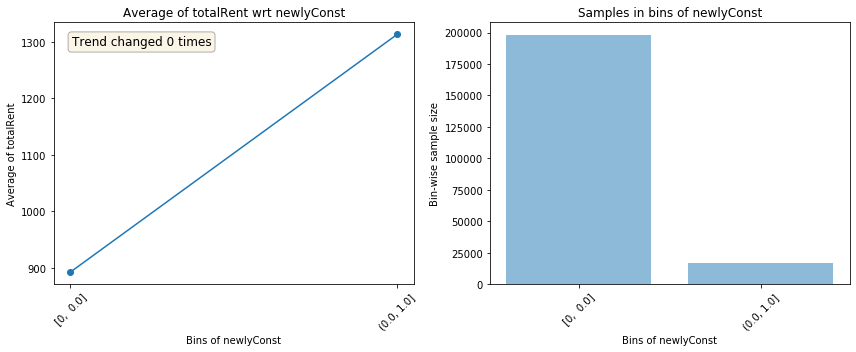

--------------------------------------------------------------------------------------------------------------


                                          Plots for balcony                                           


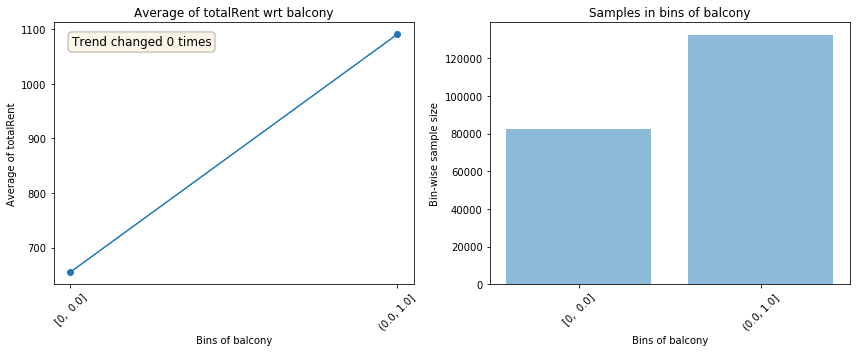

--------------------------------------------------------------------------------------------------------------


                                         Plots for hasKitchen                                         


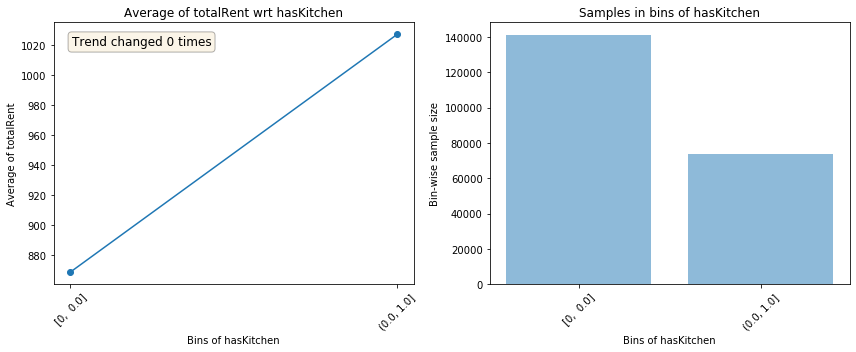

--------------------------------------------------------------------------------------------------------------


                                           Plots for cellar                                           


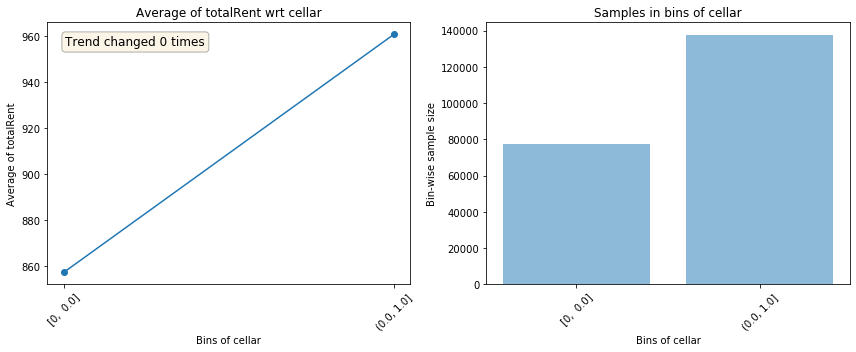

--------------------------------------------------------------------------------------------------------------


                                            Plots for lift                                            


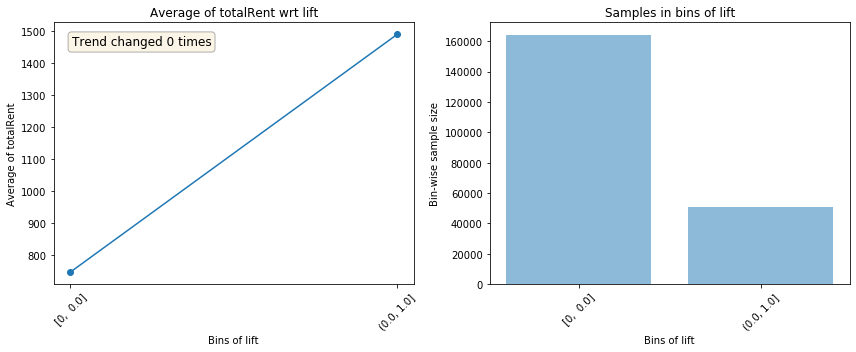

--------------------------------------------------------------------------------------------------------------


                                           Plots for garden                                           


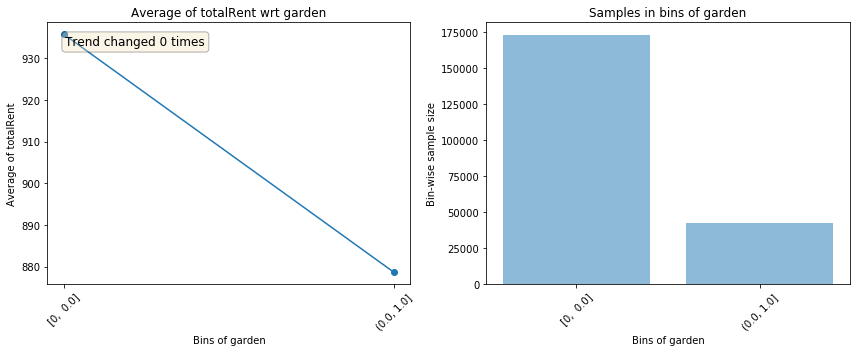

--------------------------------------------------------------------------------------------------------------




In [ ]:
#Visualize feature
get_univariate_plots(data = data, target_col = target_class, features_list = bool_features)

## Transform2Categorical

In [ ]:
data_clean[transform2categorical].dtypes

heatingType               object
telekomTvOffer            object
firingTypes               object
condition                 object
interiorQual              object
typeOfFlat                object
energyEfficiencyClass     object
electricityBasePrice     float64
petsAllowed               object
dtype: object

In [ ]:
data_clean[transform2categorical].isnull().sum()

heatingType               35721
telekomTvOffer            25961
firingTypes               45509
condition                 54757
interiorQual              89936
typeOfFlat                29226
energyEfficiencyClass    152590
electricityBasePrice     177357
petsAllowed               91529
dtype: int64

heatingType ['central_heating' 'gas_heating' 'self_contained_central_heating'
 'district_heating' 'floor_heating' 'heat_pump' nan 'wood_pellet_heating'
 'electric_heating' 'oil_heating' 'combined_heat_and_power_plant'
 'night_storage_heater' 'stove_heating' 'solar_heating']
telekomTvOffer ['ONE_YEAR_FREE' nan 'NONE' 'ON_DEMAND']
firingTypes ['district_heating:electricity' 'oil' 'gas' 'district_heating'
 'natural_gas_light' nan 'wood_chips' 'bio_energy' 'geothermal'
 'pellet_heating' 'natural_gas_heavy' 'steam_district_heating'
 'gas:electricity' 'electricity' 'local_heating' 'solar_heating:gas'
 'gas:district_heating' 'combined_heat_and_power_fossil_fuels'
 'liquid_gas' 'heat_supply' 'environmental_thermal_energy'
 'geothermal:gas' 'district_heating:local_heating' 'wind_energy'
 'solar_heating:electricity' 'gas:natural_gas_heavy' 'solar_heating'
 'solar_heating:natural_gas_light'
 'combined_heat_and_power_renewable_energy' 'gas:oil' 'hydro_energy'
 'district_heating:combined_heat_and_p

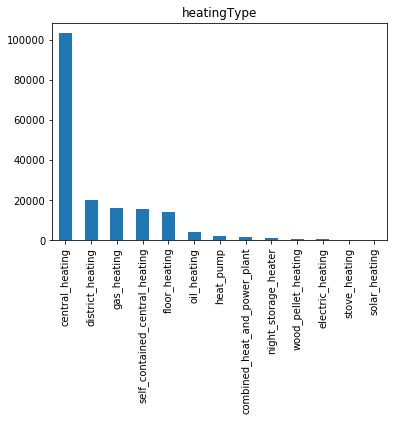

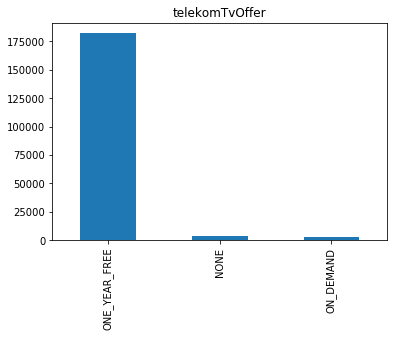

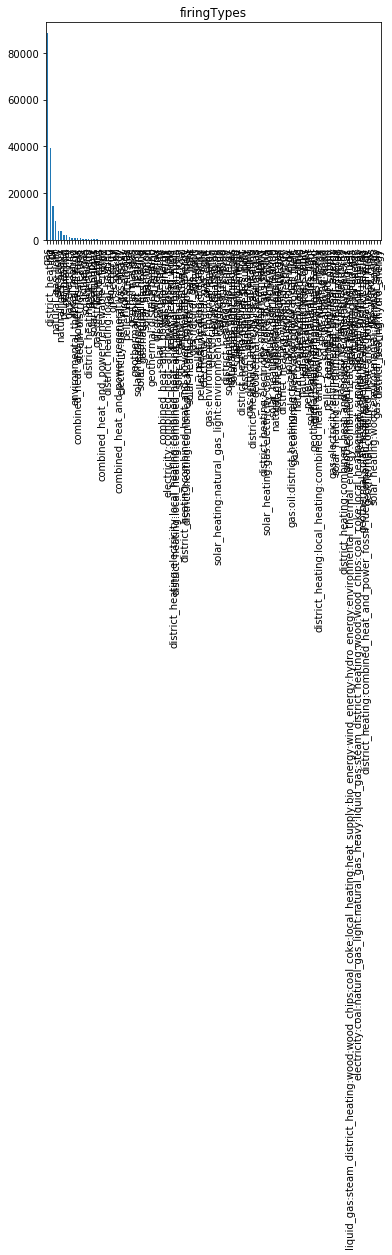

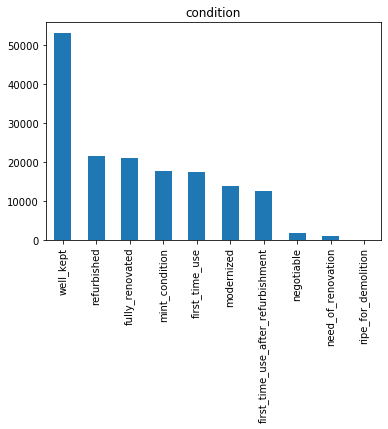

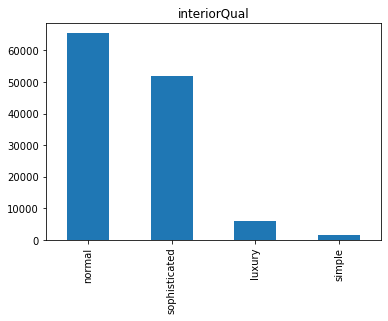

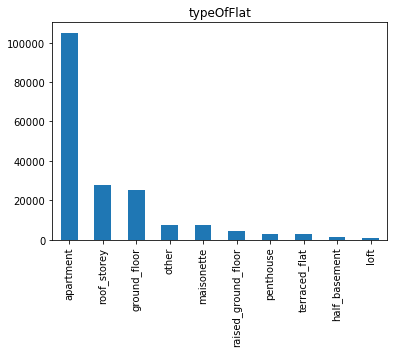

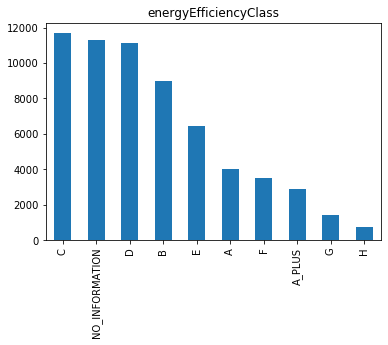

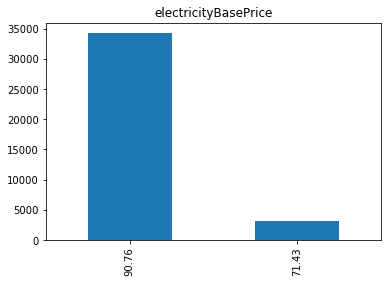

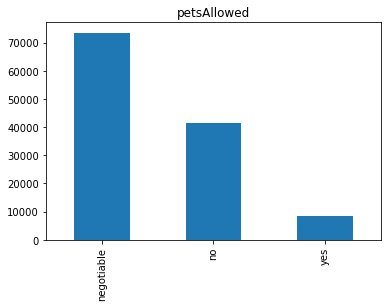

In [ ]:
describe_data(training_data = data[transform2categorical]) 

heatingType and firingTypes are kind of the same

telekomTvOffer will give almost no information cause of the huge unbalance.

condition gives a lot of information and classes should be conserved as they are.

interior quality also conserve the classes with an extra nan class. This one has more missing values than condition, so we could theoretically predict interior quality from condition.

typeOfFlat also gives a lot of information we should mantain all clases as they are

Energy efficiency class we can convert to integer

electricitybaseprice can be useful to compute the costs. There are a lot of missing values though.

PetsaAllowed I can put the nan class in negociable. 0-> no , 0.5 negociable, 1 yes

For feature FiringTypes I will group the classes that have few examples (1500). I could divide the string by the : character and 

For features energyEfficiencyClass I will encode the values as a continuous variable


------------------------------------------------
heatingType
heatingType
central_heating                   87577
combined_heat_and_power_plant      1393
district_heating                  17033
electric_heating                    580
floor_heating                     12490
gas_heating                       14577
heat_pump                          1755
night_storage_heater                915
oil_heating                        3667
self_contained_central_heating    11786
solar_heating                       113
stove_heating                       195
wood_pellet_heating                 710
Name: totalRent, dtype: int64
35721


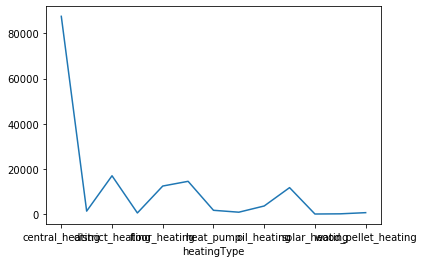

heatingType
central_heating                    749.865177
combined_heat_and_power_plant     1139.935958
district_heating                   786.778251
electric_heating                   665.682345
floor_heating                     1316.669986
gas_heating                        818.690169
heat_pump                         1190.977915
night_storage_heater               572.544721
oil_heating                        836.940515
self_contained_central_heating     734.675170
solar_heating                     1138.916726
stove_heating                      610.587692
wood_pellet_heating               1054.434690
Name: totalRent, dtype: float64


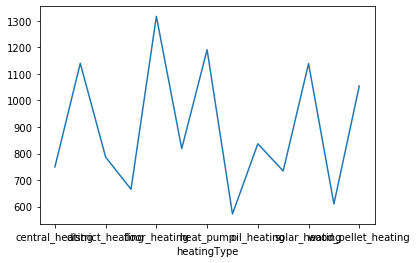

------------------------------------------------
telekomTvOffer
telekomTvOffer
NONE               3271
ONE_YEAR_FREE    154565
ON_DEMAND          2457
Name: totalRent, dtype: int64
25961


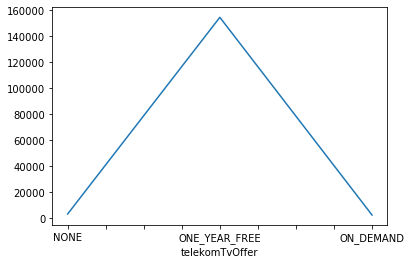

telekomTvOffer
NONE             704.089181
ONE_YEAR_FREE    796.686614
ON_DEMAND        740.680012
Name: totalRent, dtype: float64


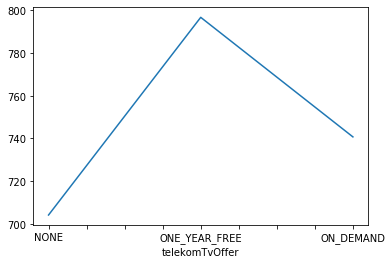

------------------------------------------------
firingTypes
firingTypes
bio_energy                               78
coal                                     34
coal_coke                                 3
combined_heat_and_power_bio_energy       10
combined_heat_and_power_fossil_fuels    674
                                       ... 
solar_heating:wood_chips                  1
steam_district_heating                  588
wind_energy                              13
wood                                    117
wood_chips                              134
Name: totalRent, Length: 122, dtype: int64
45509


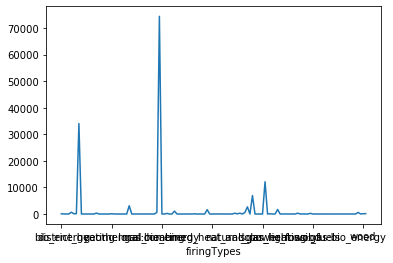

firingTypes
bio_energy                              1105.821923
coal                                     679.099118
coal_coke                                997.666667
combined_heat_and_power_bio_energy      1025.100000
combined_heat_and_power_fossil_fuels    1195.933412
                                           ...     
solar_heating:wood_chips                 630.000000
steam_district_heating                   757.994796
wind_energy                             1250.000000
wood                                     853.975983
wood_chips                              1042.439627
Name: totalRent, Length: 122, dtype: float64


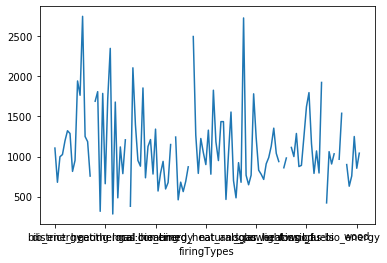

------------------------------------------------
condition
condition
first_time_use                        14443
first_time_use_after_refurbishment    10926
fully_renovated                       17898
mint_condition                        15243
modernized                            11879
need_of_renovation                      909
negotiable                             1483
refurbished                           19531
ripe_for_demolition                       3
well_kept                             44346
Name: totalRent, dtype: int64
54757


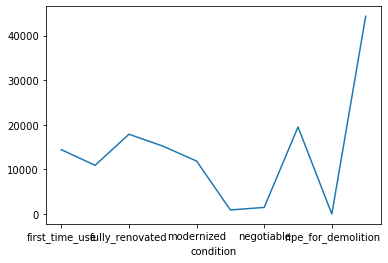

condition
first_time_use                        1311.367536
first_time_use_after_refurbishment     951.490836
fully_renovated                        739.167093
mint_condition                        1182.505224
modernized                             733.782350
need_of_renovation                     605.353795
negotiable                             645.634788
refurbished                            639.345261
ripe_for_demolition                    882.833333
well_kept                              710.018253
Name: totalRent, dtype: float64


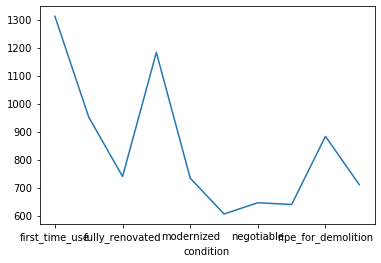

------------------------------------------------
interiorQual
interiorQual
luxury            5311
normal           59231
simple            1370
sophisticated    45390
Name: totalRent, dtype: int64
89936


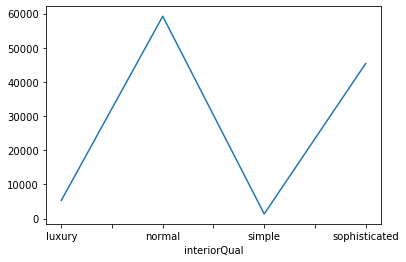

interiorQual
luxury           1846.462777
normal            616.165763
simple            557.753905
sophisticated    1071.077724
Name: totalRent, dtype: float64


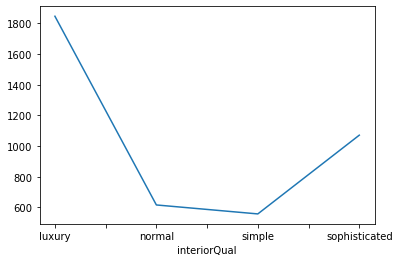

------------------------------------------------
typeOfFlat
typeOfFlat
apartment              88500
ground_floor           21529
half_basement           1405
loft                     640
maisonette              6281
other                   6851
penthouse               2270
raised_ground_floor     4016
roof_storey            23897
terraced_flat           2352
Name: totalRent, dtype: int64
29226


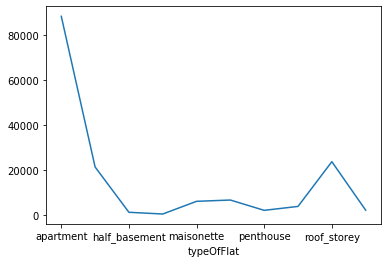

typeOfFlat
apartment               799.524671
ground_floor            780.334521
half_basement           676.309310
loft                   1429.570359
maisonette             1279.963862
other                   778.752483
penthouse              1849.507225
raised_ground_floor     757.350695
roof_storey             762.620249
terraced_flat          1169.527547
Name: totalRent, dtype: float64


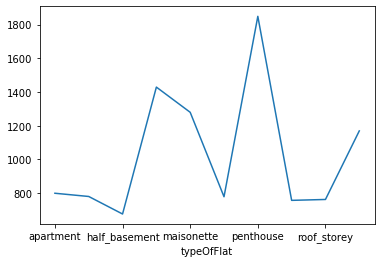

------------------------------------------------
energyEfficiencyClass
energyEfficiencyClass
A                  3239
A_PLUS             2226
B                  7476
C                  9811
D                  9163
E                  5084
F                  2713
G                  1036
H                   521
NO_INFORMATION    10223
Name: totalRent, dtype: int64
152590


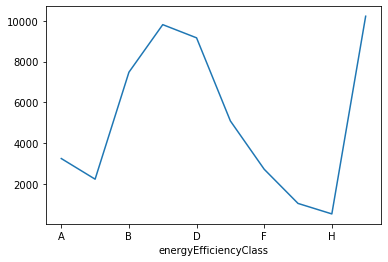

energyEfficiencyClass
A                 1248.298963
A_PLUS            1283.600719
B                  965.849757
C                  707.866726
D                  710.328338
E                  749.267734
F                  753.355345
G                  740.678243
H                  729.830192
NO_INFORMATION     844.587631
Name: totalRent, dtype: float64


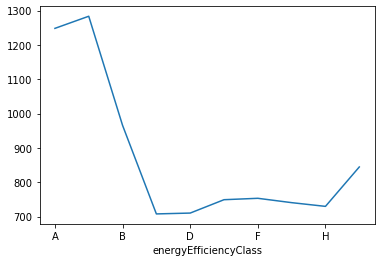

------------------------------------------------
electricityBasePrice
electricityBasePrice
71.43     2669
90.76    28813
Name: totalRent, dtype: int64
177357


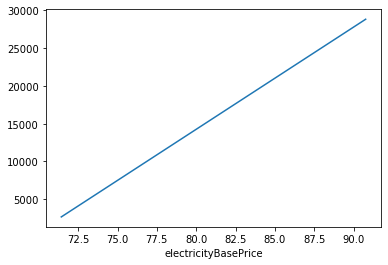

electricityBasePrice
71.43    758.541326
90.76    820.095658
Name: totalRent, dtype: float64


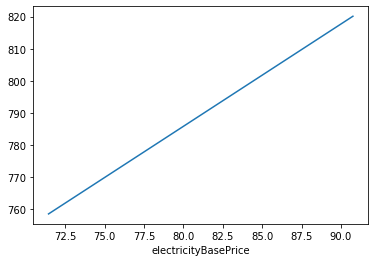

------------------------------------------------
petsAllowed
petsAllowed
negotiable    63343
no            35378
yes            7389
Name: totalRent, dtype: int64
91529


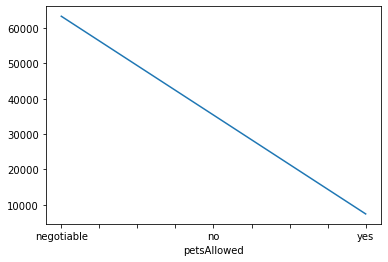

petsAllowed
negotiable    784.081931
no            908.200131
yes           785.125860
Name: totalRent, dtype: float64


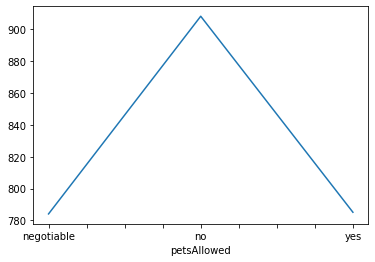

In [ ]:
#Visualize following things:
#   Plot the number of ocurrences in each class
#   Plot the mean of the price in each class to see how much it deviates ( more variation is better)
for feat_2_cat in transform2categorical:
    print('------------------------------------------------')
    print(feat_2_cat)
    print(data_clean.groupby(feat_2_cat)[target_class].count()) #count
    print(data_clean[feat_2_cat].isnull().sum())                #NaN values
    data_clean.groupby(feat_2_cat)[target_class].count().plot() #count plot
    plt.show()
    print(data_clean.groupby(feat_2_cat)[target_class].mean()) #price_mean
    data_clean.groupby(feat_2_cat)[target_class].mean().plot() #price_mean plot
    plt.show()

Since there are in all cases a lot of Nan's, it makes no sense to throw that data. I then will add these values as a new class. Lightbm incorporates Nan as a separate class. If I wanted to use other models I should prepare it as another class, I leave the code for that in the function create_nan_class

In [ ]:
features_add_nan_class = ['heatingType','telekomTvOffer','condition','interiorQual','typeOfFlat',
                          'electricityBasePrice','petsAllowed']

data_clean = create_nan_class(df = data_clean, columns = features_add_nan_class)

In [ ]:
data['condition'].unique()

array([nan, 'well_kept', 'fully_renovated', 'refurbished',
       'first_time_use', 'mint_condition', 'modernized',
       'first_time_use_after_refurbishment', 'need_of_renovation',
       'negotiable', 'ripe_for_demolition'], dtype=object)

In [ ]:
#Now it is a class rather than a nan
data_clean['condition'].unique()

array(['nan', 'well_kept', 'fully_renovated', 'refurbished',
       'first_time_use', 'mint_condition', 'modernized',
       'first_time_use_after_refurbishment', 'need_of_renovation',
       'negotiable', 'ripe_for_demolition'], dtype=object)

In [ ]:
len(data['firingTypes'].unique())

123

In [ ]:
def firing_types_clean(data):
    features_firing_to_cap = list((data.groupby('firingTypes')[target_class].count()[(data.groupby('firingTypes')[target_class].count() < 1500)]).index)
    sel = (data['firingTypes'].isin(features_firing_to_cap))
    data.loc[sel,'firingTypes'] = 'too_little_count'
    return data

In [ ]:
data_ = firing_types_clean(data_)

In [ ]:
data_['firingTypes'].unique()

array(['too_little_count', 'oil', 'gas', 'district_heating',
       'natural_gas_light', nan, 'geothermal', 'pellet_heating',
       'natural_gas_heavy', 'electricity'], dtype=object)

I will encode the feature energyEfficiencyClass as a continuous feature because of the nature of the feature. The higher the effienciency the better.

In [ ]:
data['energyEfficiencyClass'].unique()

array([nan, 'C', 'B', 'NO_INFORMATION', 'F', 'E', 'D', 'A', 'A_PLUS', 'H',
       'G'], dtype=object)

In [ ]:
def energyEfficiencyClass_transform(data):
    di = {'A_PLUS':0, 'A':1 ,"B":2, 'C':3,'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'NO_INFORMATION':9}
    data = data.replace({"energyEfficiencyClass": di})
    return data

In [ ]:
di = {'A_PLUS':0, 'A':1 ,"B":2, 'C':3,'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'NO_INFORMATION':9}

In [ ]:
data = data.replace({"energyEfficiencyClass": di})

In [ ]:
data['energyEfficiencyClass']

237905    NaN
143718    NaN
53329     NaN
198945    NaN
193723    3.0
         ... 
119879    NaN
259178    NaN
131932    NaN
146867    NaN
121958    NaN
Name: energyEfficiencyClass, Length: 215080, dtype: float64

## Transform2Continuous

In [ ]:
data_clean[continuous_features].dtypes

serviceCharge          float64
noParkSpaces           float64
baseRent               float64
livingSpace            float64
baseRentRange            int64
noRooms                float64
floor                  float64
numberOfFloors         float64
heatingCosts           float64
electricityKwhPrice    float64
dtype: object

In [ ]:
data_clean[continuous_features].isnull().sum()

serviceCharge            5493
noParkSpaces           140526
baseRent                   59
livingSpace                 0
baseRentRange               0
noRooms                     0
floor                   40998
numberOfFloors          78077
heatingCosts           146391
electricityKwhPrice    177357
dtype: int64

serviceCharge [ 94.   630.   150.   ... 166.42 187.55 137.46]
noParkSpaces [      nan 2.000e+00 1.000e+00 0.000e+00 9.000e+00 3.000e+00 4.000e+00
 6.000e+00 5.000e+00 4.000e+01 2.000e+01 2.400e+01 1.000e+01 1.300e+01
 1.800e+01 1.500e+01 3.100e+01 6.500e+01 1.600e+01 1.200e+01 2.300e+01
 1.900e+01 7.000e+00 3.200e+02 2.500e+01 5.000e+01 2.200e+01 8.000e+01
 2.100e+01 1.400e+01 8.000e+00 9.000e+01 5.500e+01 3.000e+01 3.900e+01
 6.000e+01 9.500e+01 3.800e+01 2.800e+01 1.700e+01 9.900e+01 4.500e+01
 2.700e+01 3.500e+01 8.100e+01 3.600e+01 4.800e+01 5.400e+01 2.600e+01
 1.300e+02 8.700e+01 3.300e+01 8.200e+01 7.300e+01 7.500e+01 1.500e+02
 3.400e+01 5.800e+01 7.600e+01 8.500e+01 1.100e+01 7.000e+01 6.400e+01
 6.100e+01 8.300e+01 4.600e+01 3.700e+01 9.300e+01 2.241e+03]
baseRent [ 332.84 1700.    750.   ...  232.58  920.24  290.19]
livingSpace [ 50.43 143.    83.   ...  18.34 152.97  20.61]
baseRentRange [2 8 5 4 1 7 6 3 9]
noRooms [  3.     2.     1.     2.5    4.     5.     3.5    1.5    

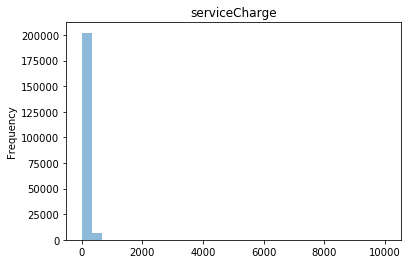

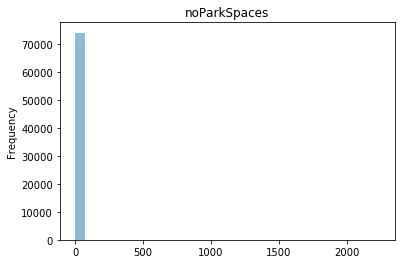

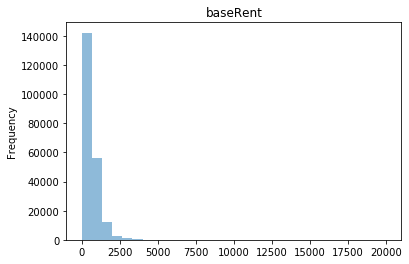

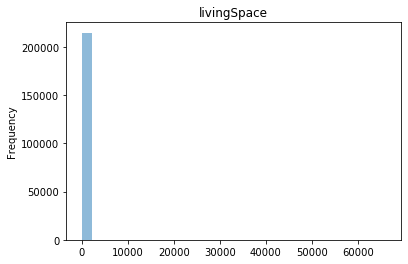

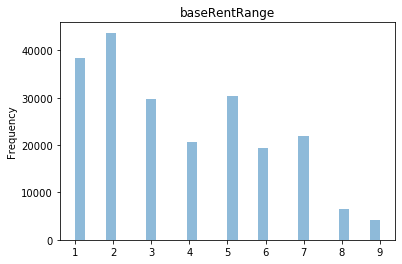

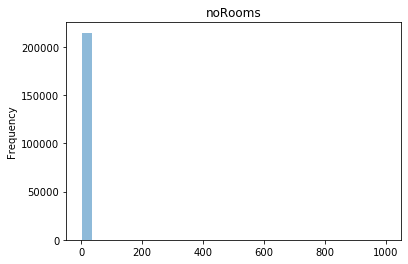

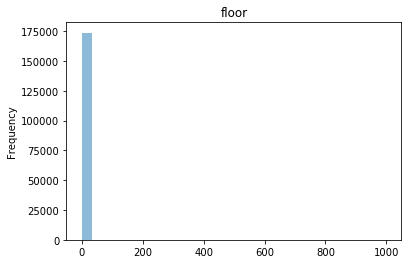

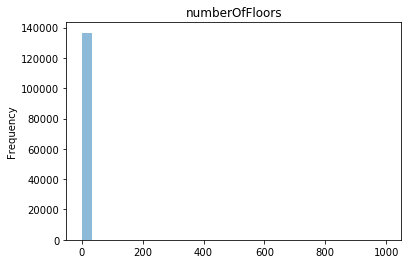

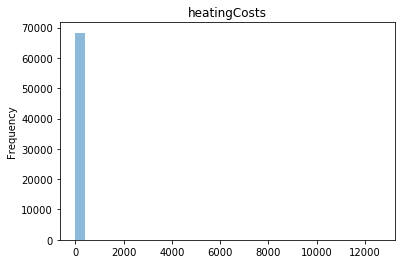

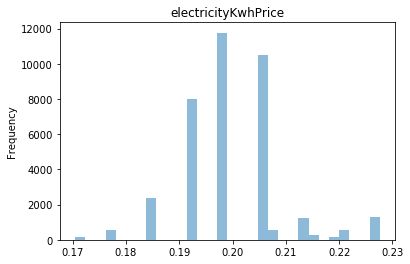

In [ ]:
describe_data(training_data = data_clean[continuous_features],categorical = False)

                                       Plots for serviceCharge                                        


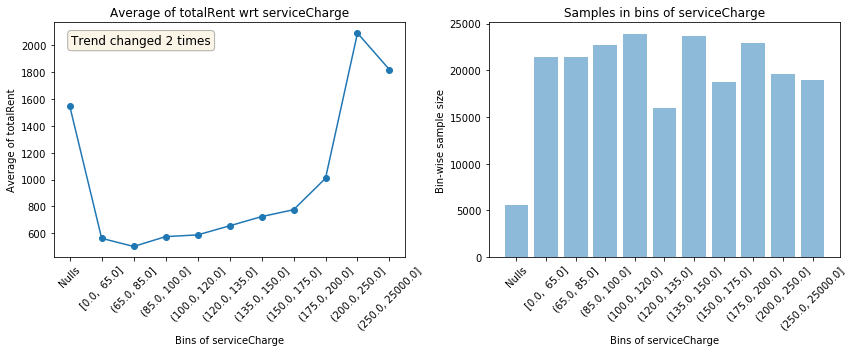

--------------------------------------------------------------------------------------------------------------


                                        Plots for noParkSpaces                                        


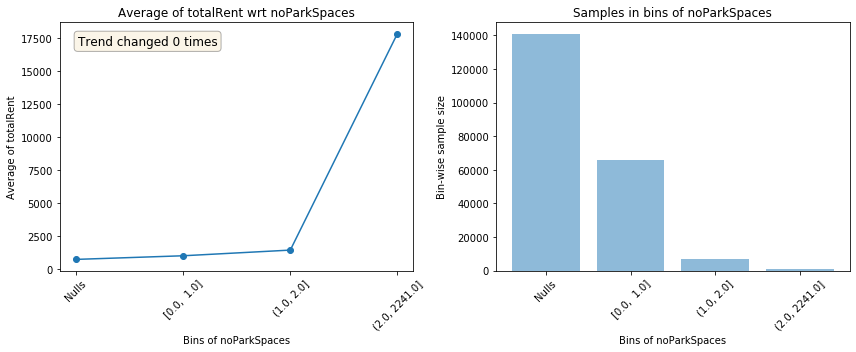

--------------------------------------------------------------------------------------------------------------


                                          Plots for baseRent                                          


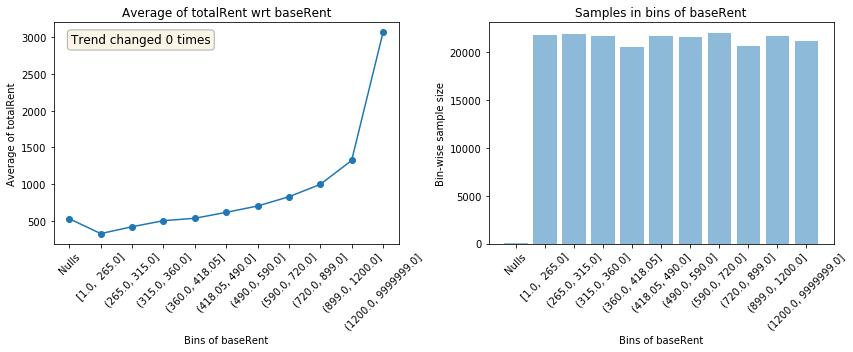

--------------------------------------------------------------------------------------------------------------


                                        Plots for livingSpace                                         


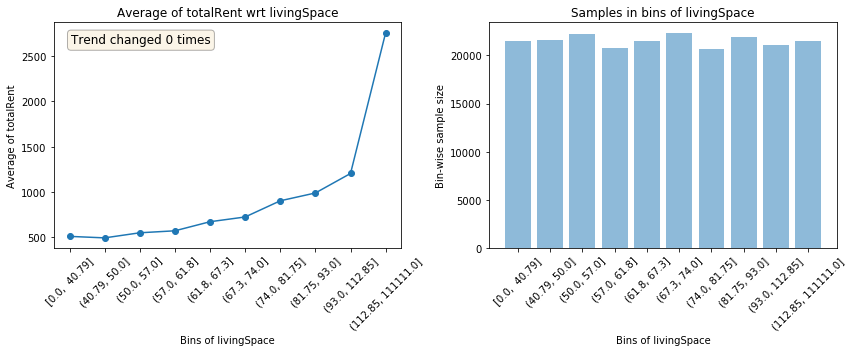

--------------------------------------------------------------------------------------------------------------


                                       Plots for baseRentRange                                        


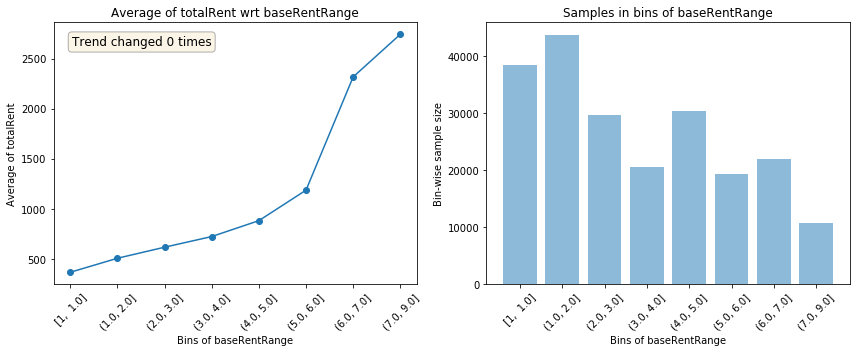

--------------------------------------------------------------------------------------------------------------


                                          Plots for noRooms                                           


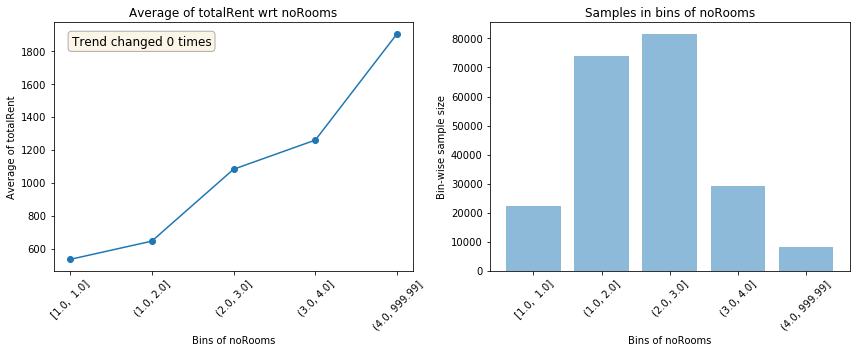

--------------------------------------------------------------------------------------------------------------


                                           Plots for floor                                            


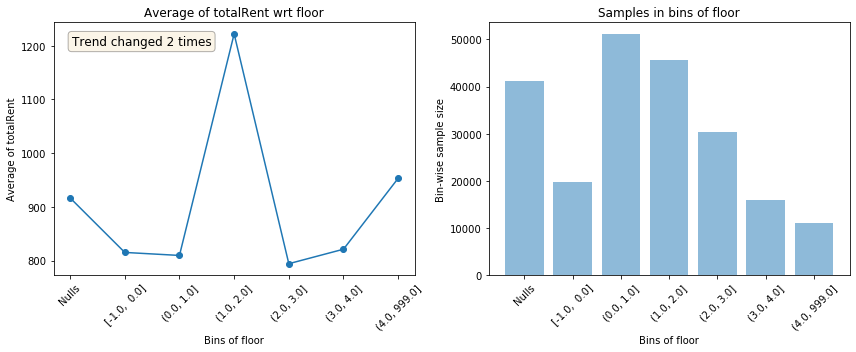

--------------------------------------------------------------------------------------------------------------


                                       Plots for numberOfFloors                                       


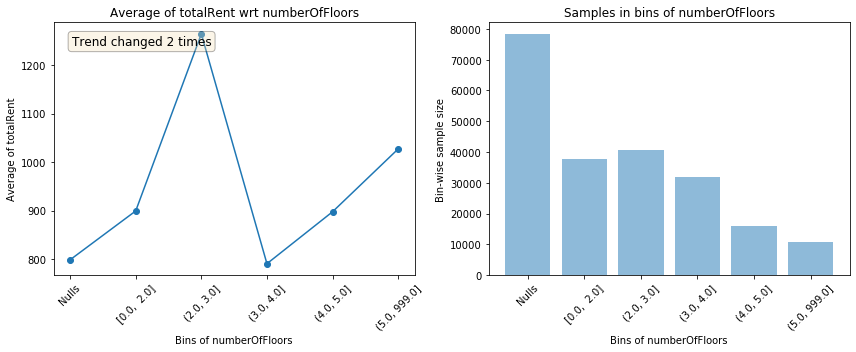

--------------------------------------------------------------------------------------------------------------


                                        Plots for heatingCosts                                        


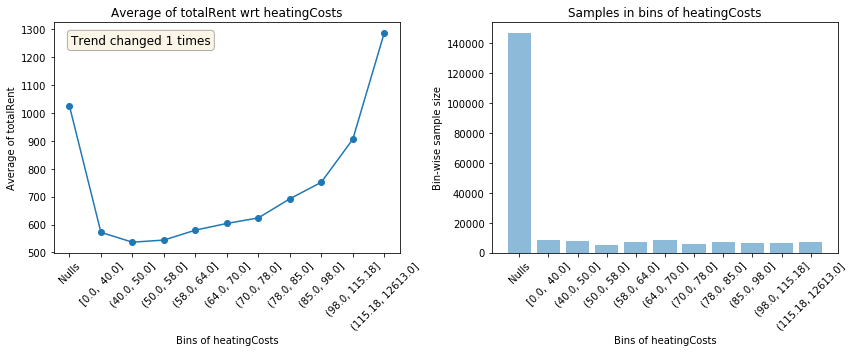

--------------------------------------------------------------------------------------------------------------


                                    Plots for electricityKwhPrice                                     


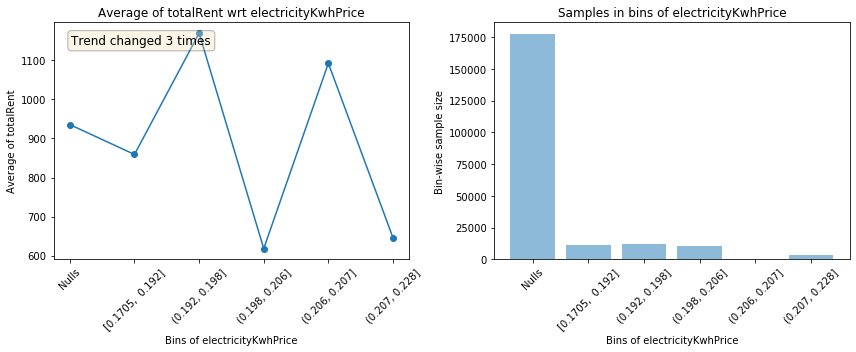

--------------------------------------------------------------------------------------------------------------




In [ ]:
get_univariate_plots(data = data, target_col = target_class, features_list = continuous_features)

serviceCharge


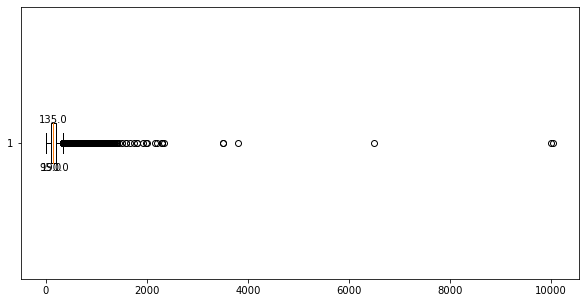

noParkSpaces


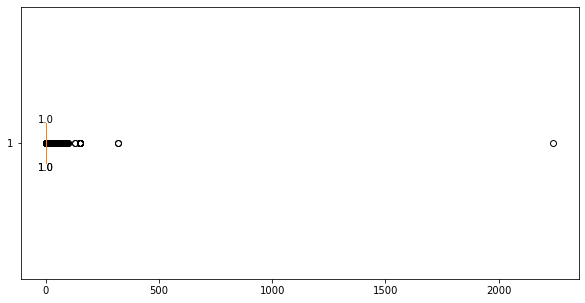

baseRent


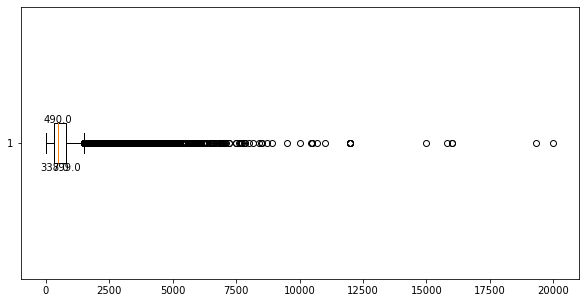

livingSpace


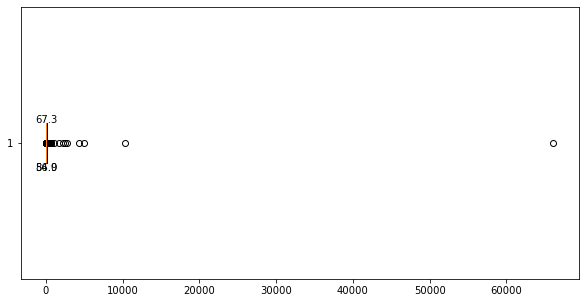

baseRentRange


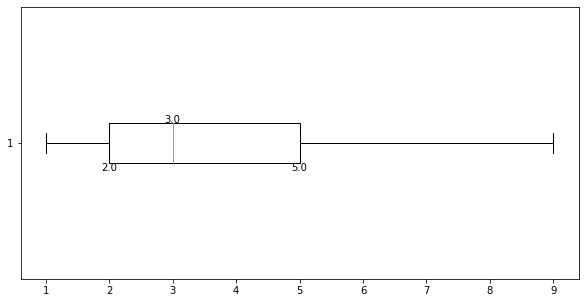

noRooms


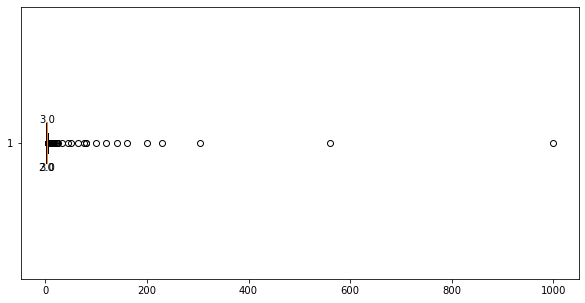

floor


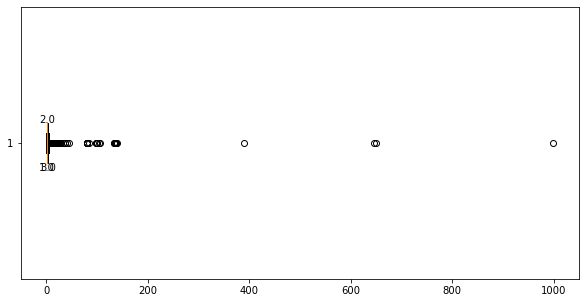

numberOfFloors


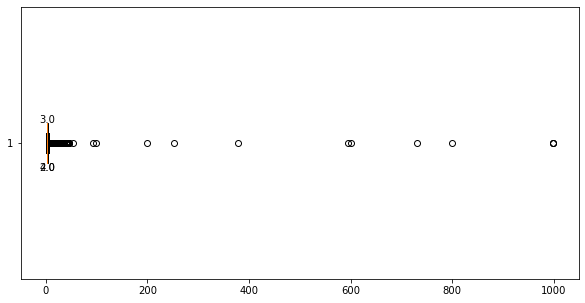

heatingCosts


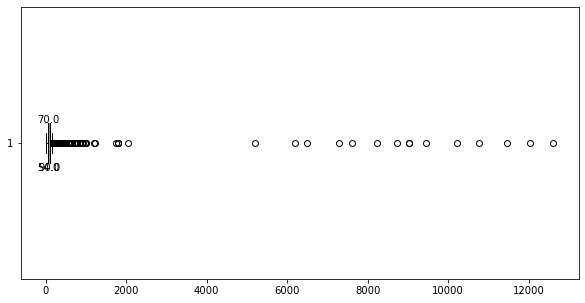

electricityKwhPrice


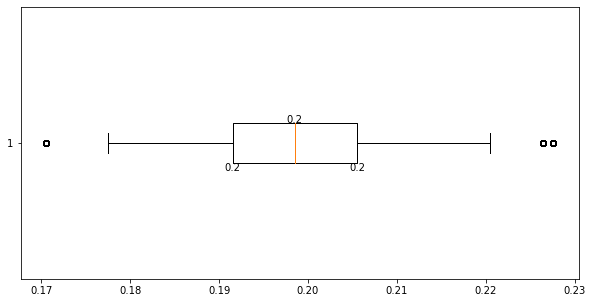

<function matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)>

In [ ]:
represent_boxplot(df_train = data_clean, columns = continuous_features)

ServiceCharge: Cap outliers from 250 ownwards because it makes not a lot of sense to have such a high service charge and the price mean of the hauses in that range does not change a lot. --> It will hopefully help our model to generalize better.

noParkSpaces: Leave the option with the data as it is and without outliers (from 2 ownwards will be 2). I will check which one is better with CV.

noRooms: There are errors in this feature. It makes no sense to have rooms with less than 3 square meters. I will set this values to nan or to 999 cause Lightbm treat them differently. I will check which one is better in cv. The ideal case would be actually to predict the number of rooms from the other data because it can be reliably infered. I will not do it in this way cause as the examples with this characteristic are not a lot it will not bring a lot for the effor to build this approach.

floor: As it is cause there is no way to know if it is wrong or not

numberOfFloors: In the cases in which the number of Floors are lower than the floor we set numberOfFloors to floor

heatingCosts: As it is cause there is no way to know if it is wrong or not

electricityKwhPrice: As it is cause there is no way to know if it is wrong or not

In [ ]:
def cap_outliers_features(df_train,dict_features):
    '''
    Cap outliers from one value ownwards.
    '''
    for key, val in dict_features.items():
        df_train[f'{key}_capped_outliers'] = df_train[key].apply(lambda x: val if x >= val else x)
    
    return df_train

In [ ]:
def room_features(data):
    #Get noRooms that make no sense
    data['SpacePerRoom'] = data['livingSpace'] / data['noRooms']
    sel = (data['SpacePerRoom'] < 5) & (data['livingSpace'] > 5)

    #Substitute for nan
    data.loc[sel,'noRooms'] = np.nan
    data['SpacePerRoom'] = data['livingSpace'] / data['noRooms']

    #Substitute nan for -999 for having 2 options
    data['noRooms_-999'] = data['noRooms'].fillna(-999, inplace=True)
    data['SpacePerRoom_-999'] = data['SpacePerRoom'].fillna(-999, inplace=True)

    return data

In [ ]:
def floor_features(data):
    sel = data['numberOfFloors'] - data['floor'] < 0 #cases wrong (floor > numberOfFloors)
    data.loc[sel,'numberOfFloors'] = data.loc[sel,'floor']
    data['relative_floor'] = data['floor'] / data['numberOfFloors']
    
    return data

In [ ]:
dict_features = {'serviceCharge':250,
                 'noParkSpaces':2
                }

data_clean = cap_outliers_features(df_train = data_clean, dict_features = dict_features)

serviceCharge_capped_outliers


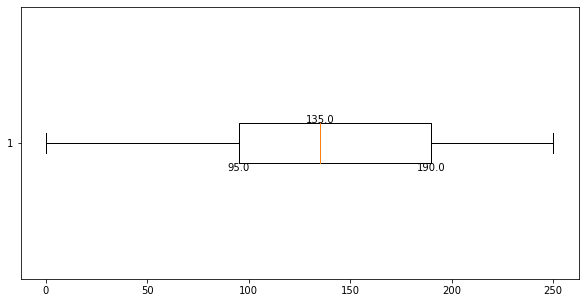

noParkSpaces_capped_outliers


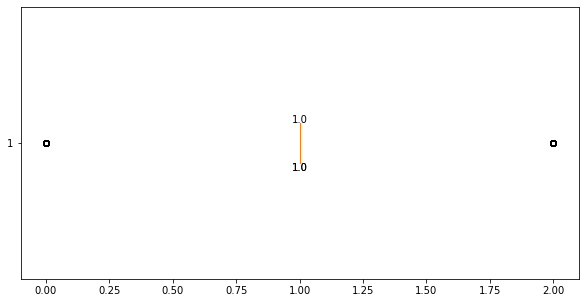

<function matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)>

In [ ]:
represent_boxplot(df_train = data_clean, columns = ['serviceCharge_capped_outliers','noParkSpaces_capped_outliers'])

In [ ]:
data_clean = floor_features(data = data_clean)

In [ ]:
sel = data['numberOfFloors'] - data['floor'] < 0
data[sel][['numberOfFloors','noRooms']]

,numberOfFloors,noRooms
8396,1.0,2.0
85958,1.0,3.0
102902,3.0,3.0
247242,2.0,5.0
98454,2.0,3.5
...,...,...
259747,0.0,2.0
205362,0.0,3.0
86416,1.0,2.0
47254,0.0,2.0


In [ ]:
#No more cases like that one
sel = data_clean['numberOfFloors'] - data_clean['floor'] < 0
data_clean[sel][['numberOfFloors','noRooms']]

,numberOfFloors,noRooms


## Telekom Features

In [ ]:
data_clean[telekom_features].dtypes

telekomUploadSpeed          float64
telekomHybridUploadSpeed    float64
dtype: object

In [ ]:
data_clean[telekom_features].isnull().sum()

telekomUploadSpeed           26544
telekomHybridUploadSpeed    178715
dtype: int64

                                     Plots for telekomUploadSpeed                                     


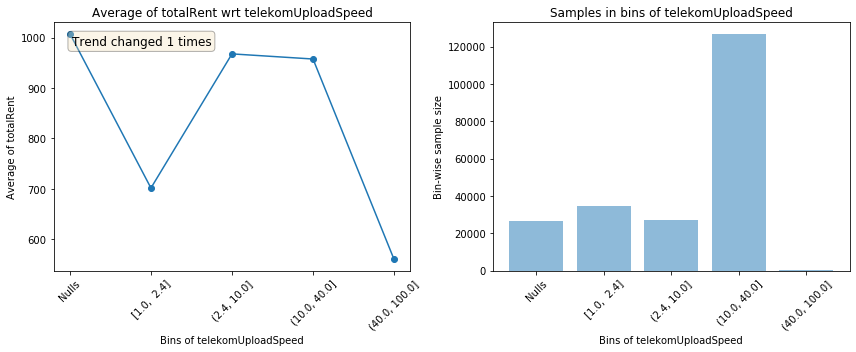

--------------------------------------------------------------------------------------------------------------


                                  Plots for telekomHybridUploadSpeed                                  


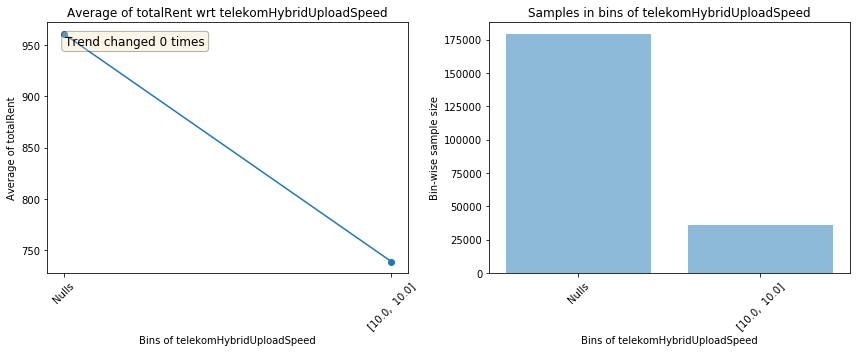

--------------------------------------------------------------------------------------------------------------




In [ ]:
get_univariate_plots(data = data, target_col = target_class, features_list = telekom_features)

As it is cause there is no way to know if it is wrong or not

## Location Features

In [ ]:
def group_statistics_mean(data_,feature,target):
    name_new_column = f'{feature}_{target}_mean'
    temp = data_.groupby(feature)[target].agg(['mean']).rename({'mean':name_new_column},axis=1)
    data_ = pd.merge(data_,temp,on=feature,how='left')
    return data_[name_new_column], name_new_column

In [ ]:
def group_statistics_size(data_,feature,target):
    name_new_column = f'{feature}_{target}_size'
    temp = data_.groupby(feature)[target].agg(['size']).rename({'size':name_new_column},axis=1)
    data_ = pd.merge(data_,temp,on=feature,how='left')
    return data_[name_new_column], name_new_column

In [ ]:
def location_features_size(data):
    for loc_feat in ['geo_bln','geo_krs','geo_plz','streetPlain']:
        data_new_feat, name_new_column = group_statistics_mean(data_ = data,
                            feature = loc_feat,
                            target = 'baseRent')

        data.loc[:,name_new_column] = np.array(data_new_feat)
        
    return data

In [ ]:
data_new_feat, name_new_column = group_statistics_size(data_ = data,
                        feature = 'geo_krs',
                        target = 'baseRent')

data.loc[:,name_new_column] = np.array(data_new_feat) 

In [ ]:
data[['geo_krs',name_new_column]] 

,geo_krs,geo_krs_baseRent_size
237905,Gelsenkirchen,2336
143718,Hamburg,2997
53329,Pinneberg_Kreis,711
198945,Aachen,1516
193723,Brandenburg_an_der_Havel,408
...,...,...
119879,Duisburg,2817
259178,Kleve_Kreis,518
131932,Kaiserslautern,477
146867,Cottbus,730


In [ ]:
data_new_feat, name_new_column = group_statistics_mean(data_ = data,
                        feature = 'geo_krs',
                        target = 'baseRent')

data.loc[:,name_new_column] = np.array(data_new_feat)

In [ ]:
data_new_feat, name_new_column = group_statistics(data_ = data,
                        feature = 'geo_plz',
                        target = 'baseRent',
                        mean = True)

data.loc[:,name_new_column] = np.array(data_new_feat)

In [ ]:
data_new_feat, name_new_column = group_statistics(data_ = data,
                        feature = 'geo_bln',
                        target = 'price_costs',
                        mean = True)

data.loc[:,name_new_column] = np.array(data_new_feat)

In [ ]:
data_new_feat, name_new_column = group_statistics_mean(data_ = data,
                        feature = 'geo_krs',
                        target = 'price_costs')

data.loc[:,name_new_column] = np.array(data_new_feat)

In [ ]:
data_new_feat, name_new_column = group_statistics(data_ = data,
                        feature = 'geo_plz',
                        target = 'price_costs',
                        mean = True)

data.loc[:,name_new_column] = np.array(data_new_feat)

In [ ]:
def location_features_mean(data):
    for target_aux in ['baseRent','price_costs']:
        for loc_feat in ['geo_bln','geo_krs','geo_plz','streetPlain']:

            data_new_feat, name_new_column = group_statistics_mean(data_ = data,
                            feature = loc_feat,
                            target = target_aux)

            data.loc[:,name_new_column] = np.array(data_new_feat)
            
    return data

In [ ]:
data_clean

## Transform2Continuous

In [ ]:
data[transform2continuous].isnull().sum()

date                    0
yearConstructed     45744
lastRefurbish      150723
dtype: int64

In [ ]:
def year_features(data):
    data['date_number'] = data['date'].apply(lambda x: 2000 + int(x[-2:]))
    data['years_old'] = data['date_number'] - data['yearConstructed']
    data['years_last_refurbish'] = data['date_number'] - data['lastRefurbish']
    
    return data

In [ ]:
data['date_number'] = data['date'].apply(lambda x: 2000 + int(x[-2:]))

In [ ]:
data['years_old'] = data['date_number'] - data['yearConstructed']

In [ ]:
data['years_last_refurbish'] = data['date_number'] - data['lastRefurbish']